# Replicate ViT using PyTorch

In this notebook I will take you through all the steps to replicate the Vision Transformer (ViT) architecture/paper with PyTorch. Paper found here: https://arxiv.org/abs/2010.11929

We will be using the dataset from Kaggle: https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset/data

In [3]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

def download_dataset_without_json(username, api_key, dataset_slug, path='./data'):
    # Set environment variables for the SDK to find
    os.environ['KAGGLE_USERNAME'] = ""
    os.environ['KAGGLE_KEY'] = ""

    # Initialize and authenticate
    # The SDK will now use the environment variables instead of kaggle.json
    api = KaggleApi()
    api.authenticate()



    print(f"Starting download for: {dataset_slug}")
    api.dataset_download_files(dataset_slug, path=".", unzip=False)
    print(f"Done! Files saved to current directory")

# --- Configuration ---
USER = ''
KEY = ''
DATASET = 'bhavikjikadara/dog-and-cat-classification-dataset'

download_dataset_without_json(USER, KEY, DATASET)

Starting download for: bhavikjikadara/dog-and-cat-classification-dataset
Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset
Done! Files saved to current directory


## Install Libraries

In [4]:
# importing module
import logging
import sys
# Creating an object
logger = logging.getLogger()
# Configure the logging
logging.basicConfig(
    level=logging.INFO, # Set the minimum logging level to display
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
# Setting the threshold of logger to DEBUG
#logger.setLevel(logging.DEBUG)

# Test messages
#logger.debug("Harmless debug Message")
#logger.info("Just an information")
#logger.warning("Its a Warning")
#logger.error("Did you try to divide by zero")
#logger.critical("Internet is down")

In [5]:
%%capture
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    logger.info(f"torch version: {torch.__version__}")
    logger.info(f"torchvision version: {torchvision.__version__}")
except:
    logger.info(f"torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    logger.info(f"torch version: {torch.__version__}")
    logger.info(f"torchvision version: {torchvision.__version__}")

In [6]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    logger.info("Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"


## Unzip PetImages folder and save into new folder called data

In [8]:
#from vit_helpers import unzip_folder

from pathlib import Path
import shutil
import os

def unzip_folder(destination: str, zipped_folder: str, data_folder: str):

  """
  Args:
    destination: directory that will hold the images
    zipped_folder: zipped directory that will be unzipped
    data_folder: directory that will exist in root and contain destination/ directory
  """
  target_file = Path(f"{zipped_folder}.zip")

  # Setup path to data folder
  data_path = Path(f"{data_folder}/")
  image_path = data_path / destination

  image_path.mkdir(parents=True, exist_ok=True)

  # Unzip PetImages.zip
  import zipfile

  with zipfile.ZipFile(target_file, "r") as zip_ref:
      print(f"Unzipping {target_file} data...")
      zip_ref.extractall(image_path)


  if image_path.is_dir():
    print(f"Successfully unzipped {zipped_folder} and saved images into {image_path}")


unzip_folder("pets", "dog-and-cat-classification-dataset", "data")




Unzipping dog-and-cat-classification-dataset.zip data...
Successfully unzipped dog-and-cat-classification-dataset and saved images into data/pets


## Split images in data folder and create train, test, and validation folders with 0.8, 0.1, 0.1 split. Save into images folder and delete data folder

In [9]:
try:
  import splitfolders
except:
  logger.info("Couldn't find splitfolders... installing it.")
  !pip install split-folders


In [10]:

#from vit_helpers import create_train_test_folders
import os
import splitfolders
def create_train_test_folders(input_folder,output_folder):


  # Split into 80% train, 10% val, 10% test
  splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))


# The directory where train/test folders will be created
output_folder = "images"
# The folder containing your original images for cats
input_folder = "data/pets/PetImages"
create_train_test_folders(input_folder, output_folder)
logger.info(f"Removing data/ folder")

shutil.rmtree("data")





Copying files: 24998 files [00:04, 6023.10 files/s]


In [11]:
# let's do a sanity check and make sure there are no class imbalances
from pathlib import Path

def get_folder_counts(folder_path):
  split_folder_path = folder_path.split("/")
  split_type = split_folder_path[2]
  pet_type = split_folder_path[3]

  # Define the path to your folder
  folder_path = Path(folder_path)
  counts = sum(1 for entry in folder_path.iterdir() if entry.is_file())
  return f"Number of files in {pet_type} {split_type} {folder_path}: {counts}"

folder_list = ['./images/test/Cat','./images/test/Dog','./images/train/Cat','./images/train/Dog']
for item in folder_list:
  print(get_folder_counts(item))



Number of files in Cat test images/test/Cat: 1251
Number of files in Dog test images/test/Dog: 1251
Number of files in Cat train images/train/Cat: 9999
Number of files in Dog train images/train/Dog: 9999


## Create DataLoaders

In [12]:
from torchvision import transforms

# Create image size
IMG_SIZE = 224 # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
                                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor()
])

logger.info(f"Manually created transforms: {manual_transforms}")

In [13]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [14]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our smaller hardware... can always scale up later)
BATCH_SIZE = 32
train_dir = "images/train"
test_dir = "images/test"

# Create DataLoaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

logger.info(class_names)

In [15]:
# another way to see if there are class imbalances
from collections import Counter

# Access the targets and count
train_counts = Counter(train_dataloader.dataset.targets)
test_counts = Counter(test_dataloader.dataset.targets)

logger.info("Train Class distribution:", train_counts)
logger.info("Test distribution:", test_counts)

## Show one image as a sanity check

In [16]:
# suppress DEBUG messages

logging.getLogger('PIL').setLevel(logging.INFO)

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

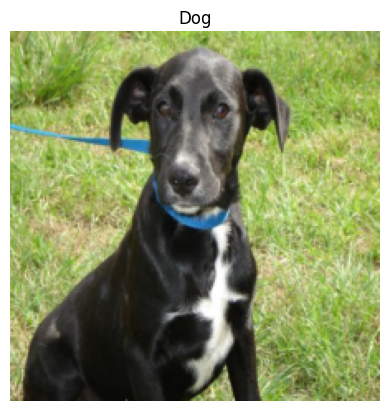

In [17]:
# Plot the image with matplotlib
# suppress DEBUG messages
logging.getLogger('matplotlib').setLevel(logging.INFO)
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False);

In [18]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initilaize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # from Table 1 for ViT-Base
    super().__init__()

    self.patch_size = patch_size

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0, 2, 1)

# Paper Replicating: Vision Transformer with PyTorch - Part 1-Create Embeddings
## Create Patches, Class Token and Position Embedding
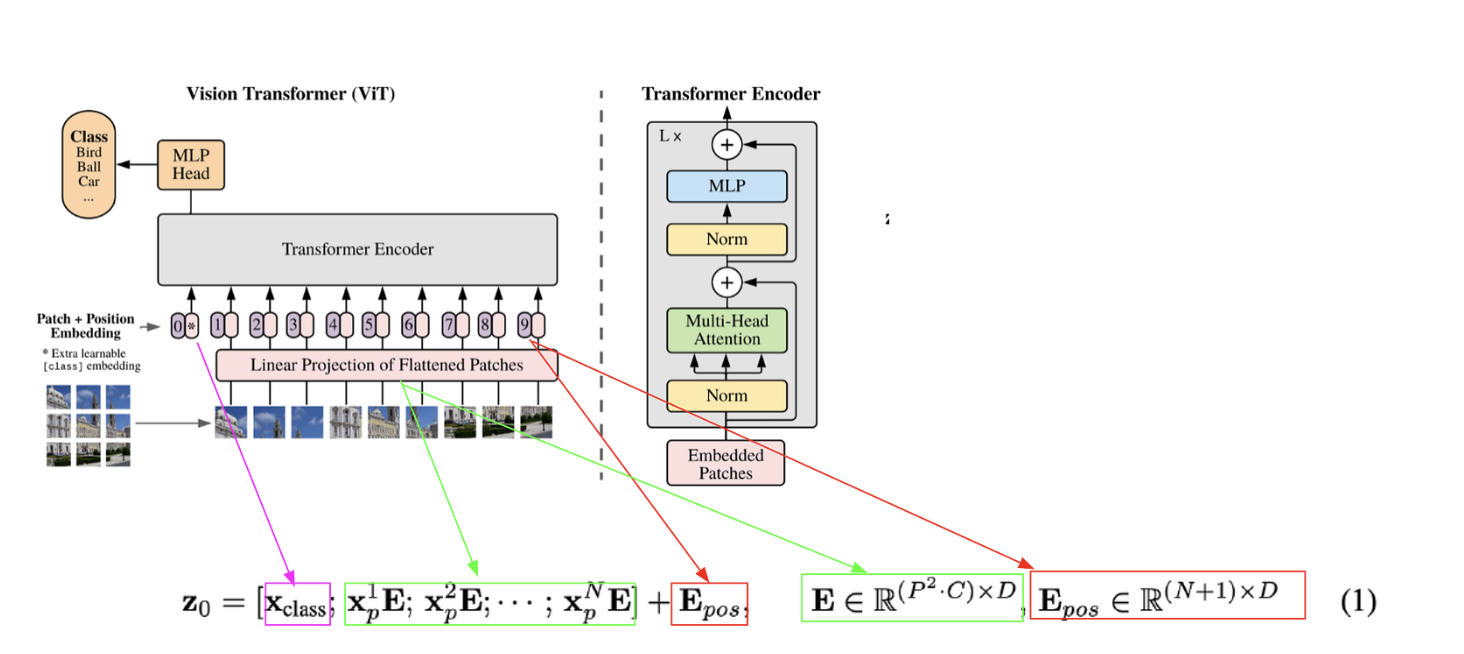

In [19]:
# set seed so code is reproducible
torch.manual_seed(42)
# Set the seed for CUDA torch operations (ones that happen on the GPU)
torch.cuda.manual_seed(42)

# set variables
height = 224 # H ("The training resolution is 224."), number from paper
width = 224 # W, number from paper
color_channels = 3 # Three color channels
patch_size = 16 # P, number from paper

height, width = image.shape[1], image.shape[2]

# Get image tensor and add batch dimension
x = image.unsqueeze(0)

# Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768) # Number from Hidden size, in paper

# Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)

# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.rand(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable

# Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)

# Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.rand(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding


 # Paper Replicating: Vision Transformer with PyTorch - Part 2-Create Self Attention and Perceptron
 ## Multi-Head Self Attention (MSA)
 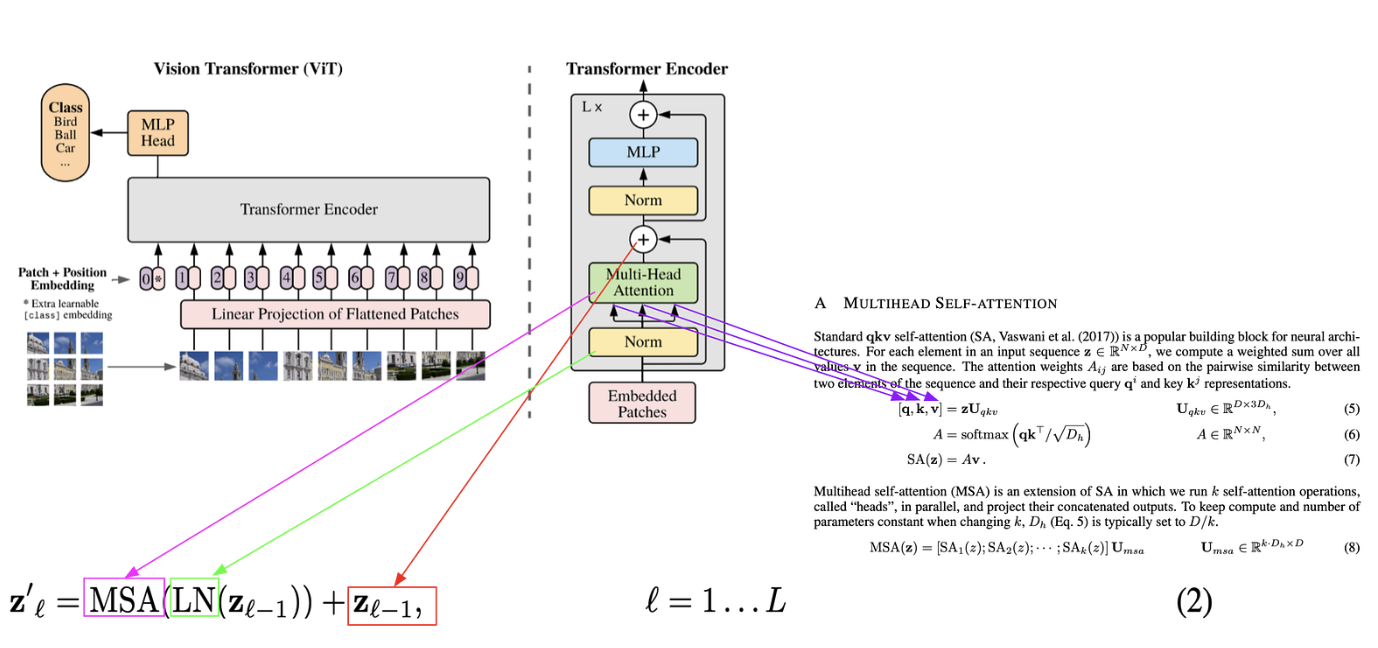

In [20]:
"""NOTE: We will be calling the MultiheadAttention() class built into PyTorch"""
# Create a class that inherits from nn.Module
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the Multi-Head Attention (MSA) layer, use PyTorch built in class
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

# Paper Replicating: Vision Transformer with PyTorch - Part 2-Create Self Attention and Perceptron
## Multilayer Perceptron (MLP)
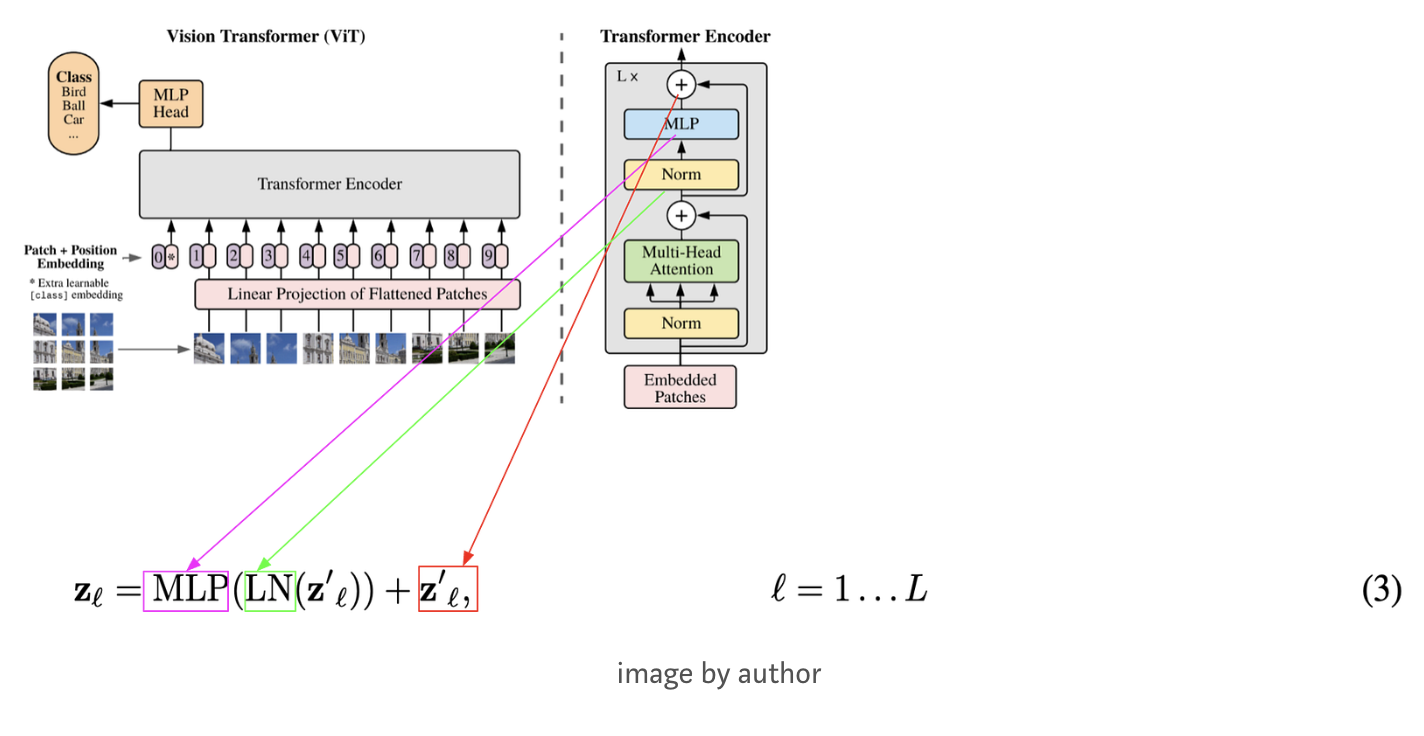

In [21]:

# Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

# Paper Replicating: Vision Transformer with PyTorch -  Part 3-Putting it all Together

In [22]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table 1, 768 for ViT-Base
               num_heads:int=12, # from table 1
               mlp_size:int=3072, # from table 1
               mlp_dropout:int=0.1, # from table 3
               attn_dropout:int=0):
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3
    return x

In [23]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [24]:
# Let's do a sanity check and make sure we didn't miss anything

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.4366, -0.5922]], grad_fn=<AddmmBackward0>)

In [25]:

# create model summary and save to file
from torchinfo import summary
patch_size = 16

model_stats = summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

summary_str = str(model_stats)

# 3. Write the string to a text file
file_path = "model_summary.txt"
with open(file_path, "w") as f:
    f.write(summary_str)

logger.info(f"Model summary saved to {file_path}")

In [26]:
from going_modular.going_modular import engine
# Set the seed for general torch operations
torch.manual_seed(42)
# Set the seed for CUDA torch operations (ones that happen on the GPU)
torch.cuda.manual_seed(42)

optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 1 | train_loss: 0.7257 | train_acc: 0.5012 | test_loss: 0.6999 | test_acc: 0.4949


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 2 | train_loss: 0.6957 | train_acc: 0.4975 | test_loss: 0.6959 | test_acc: 0.4949


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 3 | train_loss: 0.6936 | train_acc: 0.4936 | test_loss: 0.6933 | test_acc: 0.4949


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 4 | train_loss: 0.6932 | train_acc: 0.4943 | test_loss: 0.6931 | test_acc: 0.5051


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 5 | train_loss: 0.6932 | train_acc: 0.4967 | test_loss: 0.6932 | test_acc: 0.4949


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 6 | train_loss: 0.6932 | train_acc: 0.5010 | test_loss: 0.6931 | test_acc: 0.5051


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 7 | train_loss: 0.6932 | train_acc: 0.4998 | test_loss: 0.6931 | test_acc: 0.5051


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 8 | train_loss: 0.6932 | train_acc: 0.4991 | test_loss: 0.6931 | test_acc: 0.4949


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 9 | train_loss: 0.6932 | train_acc: 0.4959 | test_loss: 0.6931 | test_acc: 0.5051


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 10 | train_loss: 0.6932 | train_acc: 0.5006 | test_loss: 0.6932 | test_acc: 0.4949


In [27]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


Loss is showing a downward trend which is what is expected when the model is learning. However, Accuracy jumps all over the place, indicating it is not able to correctly classify a dog vs a cat.
These results are likely because of the difference in data resources and training regime of our ViT model versus the ViT paper.

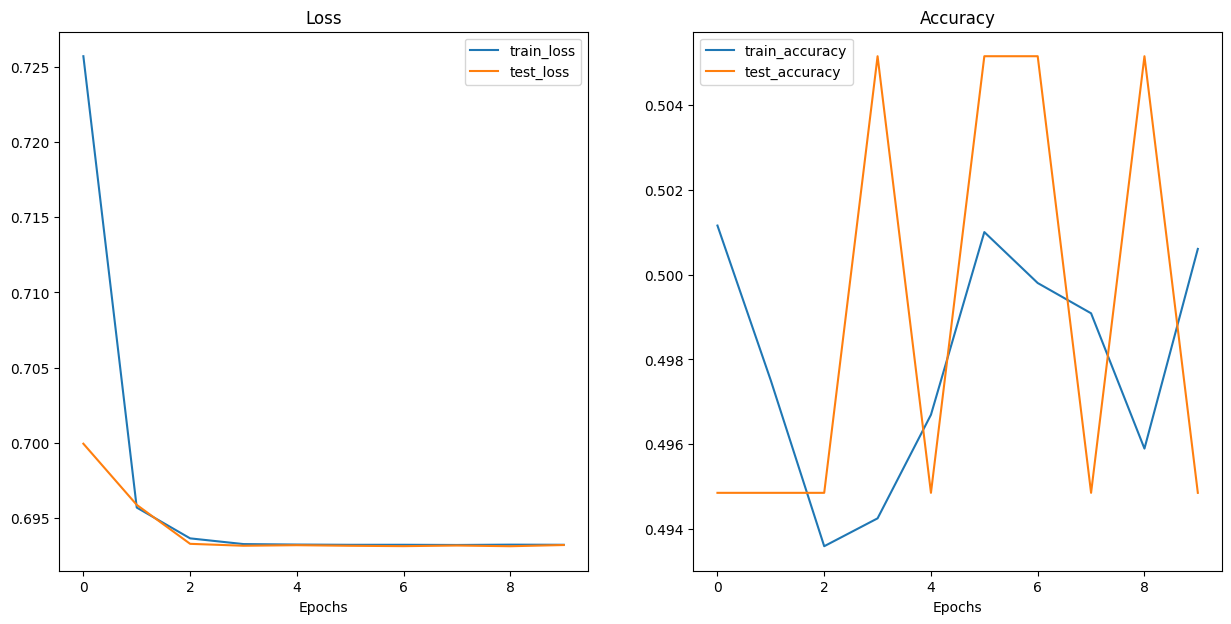

In [28]:

plot_loss_curves(results)

# Let's use a PyTorch pre-train model
### But why? You may ask.
### From the paper:
Reading the ViT paper section 4.2:

> Add blockquote



Finally, the ViT-L/16 model pre-trained on the public ImageNet-21k dataset performs well on most datasets too, while taking fewer resources to pre-train: it could be trained using a standard cloud TPUv3 with 8 cores in approximately 30 days.

### Meaning that, we do not have the resources to create an doppelganger of ViT. This is completely okay! For this, it's not about the destination - it's about the journey!

In [29]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.9.1+cu128
0.24.1+cu128


In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [31]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [32]:
# # Print a summary using torchinfo (uncomment for actual output)
pre_trained_model_stats = summary(model=pretrained_vit,
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         # col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
         row_settings=["var_names"]
 )


pre_trained_summary_str = str(pre_trained_model_stats)

# 3. Write the string to a text file
pre_trained_file_path = "pre_trained_model_summary.txt"
with open(pre_trained_file_path, "w") as f:
    f.write(pre_trained_summary_str)

logger.info(f"Model summary saved to {pre_trained_file_path}")

If you open up the document to the pre-trained model summary you'll see the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

And the number of parameters in the PyTorch pre-trained model is 85,800,963, which is the same as our custom made ViT model above.

But the number of trainable parameters for pretrained_vit is a lot lower than our custom ViT at only 2,307 compared to 85,800,963
Note: all parameters are trainable in our custom ViT since we made it.

This means the pre-trained model should train a lot faster!
We could experiment with a larger batch size since less parameter updates are going to be taking up memory.

In [33]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [34]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 1 | train_loss: 0.0494 | train_acc: 0.9877 | test_loss: 0.0269 | test_acc: 0.9937


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 2 | train_loss: 0.0252 | train_acc: 0.9923 | test_loss: 0.0263 | test_acc: 0.9937


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 3 | train_loss: 0.0214 | train_acc: 0.9942 | test_loss: 0.0233 | test_acc: 0.9933


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 4 | train_loss: 0.0196 | train_acc: 0.9939 | test_loss: 0.0244 | test_acc: 0.9925


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 5 | train_loss: 0.0179 | train_acc: 0.9947 | test_loss: 0.0241 | test_acc: 0.9921


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 6 | train_loss: 0.0164 | train_acc: 0.9947 | test_loss: 0.0240 | test_acc: 0.9921


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 7 | train_loss: 0.0154 | train_acc: 0.9957 | test_loss: 0.0251 | test_acc: 0.9917


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 8 | train_loss: 0.0146 | train_acc: 0.9954 | test_loss: 0.0277 | test_acc: 0.9905


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 9 | train_loss: 0.0140 | train_acc: 0.9958 | test_loss: 0.0249 | test_acc: 0.9917


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 10 | train_loss: 0.0128 | train_acc: 0.9962 | test_loss: 0.0261 | test_acc: 0.9917


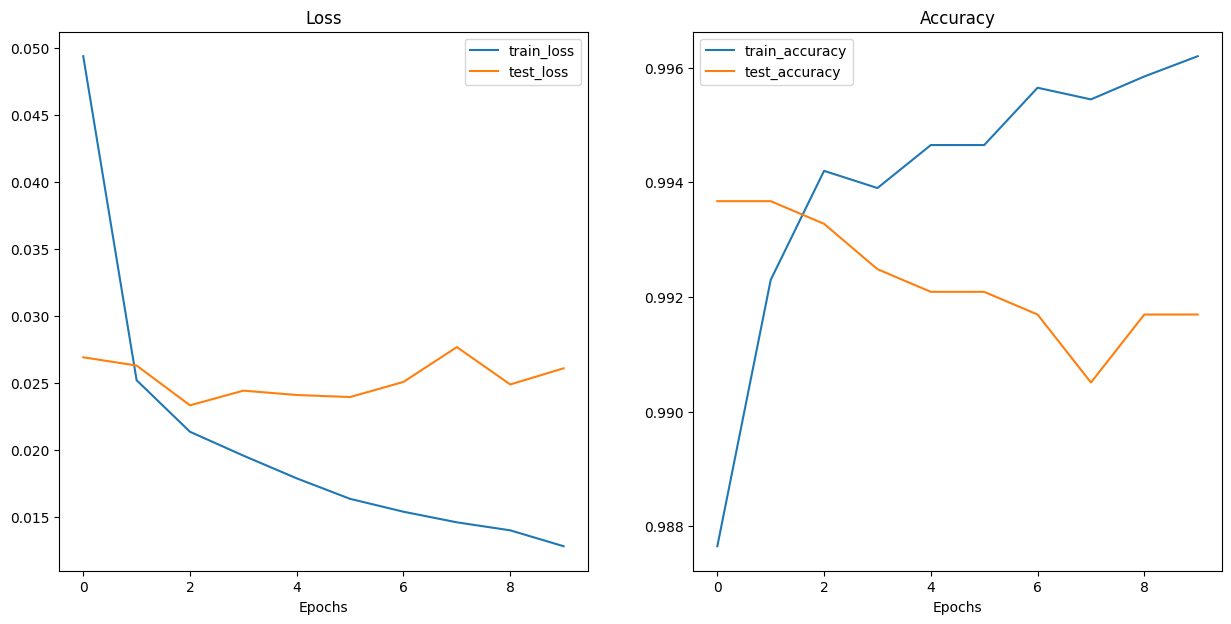

In [35]:
# Plot the loss curves

plot_loss_curves(pretrained_vit_results)

Amazing!! That is the beauty of transfer learning!! We get even better results with less training time and same model architecture.